# ASTRO 530 Homework 4 - Olivier Gilbert - Oct 29 2025

## 1.

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as cst
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
plt.rc("axes", labelsize=16) 
T_eff = 5800*u.K # K
R_star = 1*cst.R_sun

wav = np.logspace(np.log10(0.05),np.log10(1000),100)*u.um

### a)

We start with a simple 2-component disk model

---Disk model---
	Component 0 : Disk(T=300.0 K, r=[0.1 AU,5.0 AU])
	Component 1 : Disk(T=50.0 K, r=[5.0 AU,100.0 AU])
----------------



/opt/anaconda3/envs/astro532/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/bq/dl39th_j0f71bgv_rs5frsgm0000gq/T/ipykernel_80820/1127370896.py:32: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(wav.value), np.log10((wav*disk.L_lambda(wav)).value), ls="--", lw=2, label=f"Component {i}")
/var/folders/bq/dl39th_j0f71bgv_rs5frsgm0000gq/T/ipykernel_80820/1127370896.py:33: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(wav.value), np.log10((wav*self.L_lambda(wav)).value), color=main_col, lw=2, label=label)


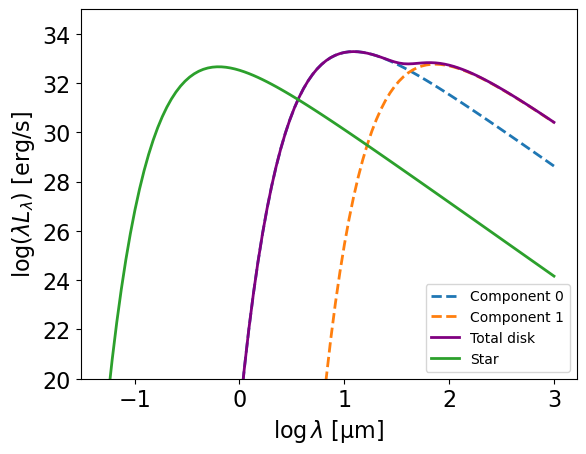

In [75]:
from scipy.integrate import quad
def planck(wav, T):
    if T == 0: return 0
    return 2*cst.h*cst.c**2*wav**(-5) / (np.exp(cst.h*cst.c/(wav*cst.k_B*T))-1)

def L_lamb_star(wav):
    return (planck(wav, T_eff) * (2*np.pi*R_star**2)).to(u.erg / u.s / u.um)

class MultiDisk:
    def __init__(self, disks):
        self.disks = disks
    def L_lambda(self, wav):
        L_lam = 0
        for i in range(len(self.disks)):
            L_lam += self.disks[i].L_lambda(wav)
        return L_lam
    def __str__(self):
        s = f"---Disk model---\n"
        for i, disk in enumerate(self.disks):
            s += f"\tComponent {i} : {disk.__str__()}\n"
        s += f"----------------\n"
        return s
    def __add__(self, disk2):
        if type(disk2) == MultiDisk:
            return MultiDisk(self.disks + disk2.disks)
        if type(disk2) != list:
            disk2 = [disk2]
        return MultiDisk(self.disks + disk2)
    def plot(self, plot_comps=True, main_col="purple", label="Total disk"):
        if plot_comps:
            for i, disk in enumerate(self.disks):
                plt.plot(np.log10(wav.value), np.log10((wav*disk.L_lambda(wav)).value), ls="--", lw=2, label=f"Component {i}")
        plt.plot(np.log10(wav.value), np.log10((wav*self.L_lambda(wav)).value), color=main_col, lw=2, label=label)

class Disk(MultiDisk):
    def __init__(self, spatial_extent, Temp):
        self.ri = spatial_extent[0]
        self.rf = spatial_extent[1]
        self.T = Temp
    def __str__(self):
        return f"Disk(T={self.T}, r=[{self.ri},{self.rf}])"
    def temp(self, r): # abstract method for temp
        return (self.T if r <= self.rf and r >= self.ri else 0)
    def L_lambda(self, wav):
        return (planck(wav, self.T) * (np.pi*(self.rf**2-self.ri**2))).to(u.erg / u.s / u.um)
    def __add__(self, disk2):
        return MultiDisk([self, disk2])

disk1 = Disk((0.1*u.AU,5*u.AU),300*u.K)
disk2 = Disk((5*u.AU,100*u.AU),50*u.K)
model1 = disk1+disk2
print(model1)
model1.plot()
plt.plot(np.log10(wav.value), np.log10((wav*L_lamb_star(wav)).value), lw=2, label="Star")
plt.ylim(20, 35)
plt.xlabel(r"$\log \lambda$ [$\mathrm{\mu m}$]")
plt.ylabel(r"$\log (\lambda L_\lambda)$ [$\mathrm{erg/s}$]")
plt.legend()
plt.show()

### b)

Now, we can make another class with a more complex disk model:

#### i)

/var/folders/bq/dl39th_j0f71bgv_rs5frsgm0000gq/T/ipykernel_80820/4135054919.py:22: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(wav.value), np.log10((wav*self.L_lambda(wav)).value), color=main_col, lw=2, label=label)


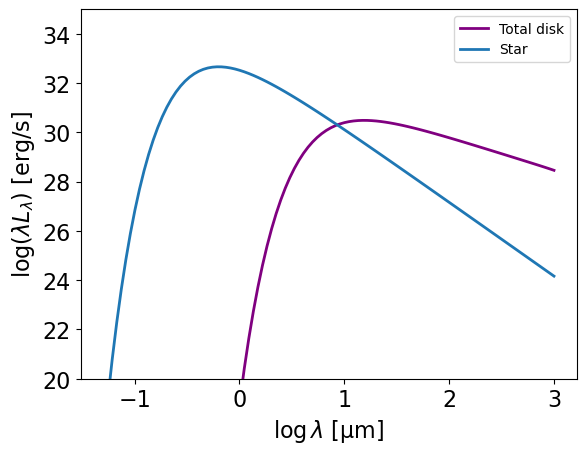

In [77]:
class ComplexDisk(MultiDisk):
    def __init__(self, spatial_extent):
        self.ri = spatial_extent[0]
        self.rf = spatial_extent[1]
    def __str__(self):
        return f"ComplexDisk(r=[{self.ri},{self.rf}])"
    def temp(self, r): # abstract method for temp
        T_ef = T_eff.to(u.K).value
        R_s = R_star.to(u.AU).value
        T_disk = T_ef*( 1/np.pi*(np.asin(R_s/r)-(R_s/r)*np.sqrt(1-(R_s/r)**2)) )**(1/4)
        return T_disk*u.K
    def L_lambda(self, wav):
        integrs = []
        for w in wav:
            func = lambda r: ((planck(w, self.temp(r))).to(u.erg/u.s/u.AU**3)).value*2*np.pi*r
            integrated = (quad(func, self.ri.to(u.AU).value, self.rf.to(u.AU).value)[0]) # erg/s/um
            integrs.append(integrated)
        return np.array(integrs)*(u.erg / u.s / u.AU).to(u.erg / u.s / u.um)
    def __add__(self, disk2):
        return MultiDisk([self, disk2])
    def plot(self, main_col="purple", label="Total disk"):
        plt.plot(np.log10(wav.value), np.log10((wav*self.L_lambda(wav)).value), color=main_col, lw=2, label=label)
    
modeli = ComplexDisk((0.1*u.AU,100*u.AU))
modeli.plot()
plt.plot(np.log10(wav.value), np.log10((wav*L_lamb_star(wav)).value), lw=2, label="Star")
plt.ylim(20, 35)
plt.xlabel(r"$\log \lambda$ [$\mathrm{\mu m}$]")
plt.ylabel(r"$\log (\lambda L_\lambda)$ [$\mathrm{erg/s}$]")
plt.legend()

#### ii)

/var/folders/bq/dl39th_j0f71bgv_rs5frsgm0000gq/T/ipykernel_80820/4135054919.py:22: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(wav.value), np.log10((wav*self.L_lambda(wav)).value), color=main_col, lw=2, label=label)


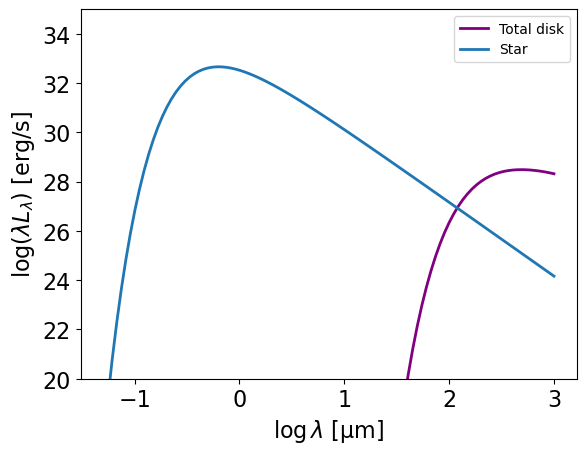

In [79]:
modelii = ComplexDisk((10*u.AU,100*u.AU))
modelii.plot()
plt.plot(np.log10(wav.value), np.log10((wav*L_lamb_star(wav)).value), lw=2, label="Star")
plt.ylim(20, 35)
plt.xlabel(r"$\log \lambda$ [$\mathrm{\mu m}$]")
plt.ylabel(r"$\log (\lambda L_\lambda)$ [$\mathrm{erg/s}$]")
plt.legend()

#### iii)

/var/folders/bq/dl39th_j0f71bgv_rs5frsgm0000gq/T/ipykernel_80820/1127370896.py:32: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(wav.value), np.log10((wav*disk.L_lambda(wav)).value), ls="--", lw=2, label=f"Component {i}")
/var/folders/bq/dl39th_j0f71bgv_rs5frsgm0000gq/T/ipykernel_80820/1127370896.py:33: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(wav.value), np.log10((wav*self.L_lambda(wav)).value), color=main_col, lw=2, label=label)


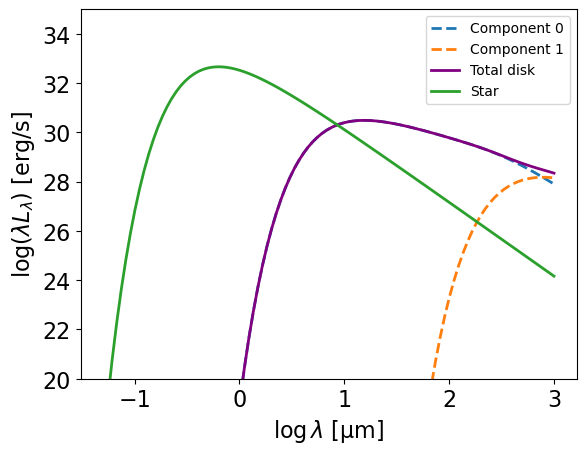

In [80]:
modeliii = ComplexDisk((0.1*u.AU,10*u.AU)) + ComplexDisk((20*u.AU,100*u.AU))
modeliii.plot()
plt.plot(np.log10(wav.value), np.log10((wav*L_lamb_star(wav)).value), lw=2, label="Star")
plt.ylim(20, 35)
plt.xlabel(r"$\log \lambda$ [$\mathrm{\mu m}$]")
plt.ylabel(r"$\log (\lambda L_\lambda)$ [$\mathrm{erg/s}$]")
plt.legend()

### c)

We first plot all three assumed structures from b):

/opt/anaconda3/envs/astro532/lib/python3.13/site-packages/astropy/units/quantity.py:659: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/var/folders/bq/dl39th_j0f71bgv_rs5frsgm0000gq/T/ipykernel_80820/4135054919.py:22: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(wav.value), np.log10((wav*self.L_lambda(wav)).value), color=main_col, lw=2, label=label)
/var/folders/bq/dl39th_j0f71bgv_rs5frsgm0000gq/T/ipykernel_80820/1127370896.py:33: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(wav.value), np.log10((wav*self.L_lambda(wav)).value), color=main_col, lw=2, label=label)


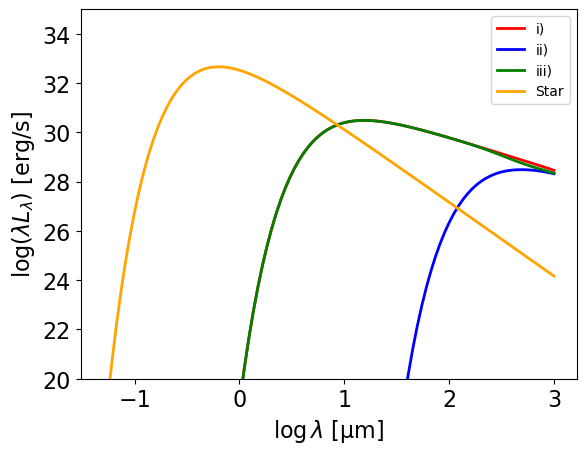

In [82]:
modeli.plot(main_col="red", label="i)")
modelii.plot(main_col="blue", label="ii)")
modeliii.plot(plot_comps=False, main_col="green", label="iii)")
plt.plot(np.log10(wav.value), np.log10((wav*L_lamb_star(wav)).value), lw=2, label="Star", color="orange")
plt.ylim(20, 35)
plt.xlabel(r"$\log \lambda$ [$\mathrm{\mu m}$]")
plt.ylabel(r"$\log (\lambda L_\lambda)$ [$\mathrm{erg/s}$]")
plt.legend()
plt.show()